In [14]:
import ants
import numpy as np
import os
from pathlib import Path
import nibabel as nb
from matplotlib import pyplot as plt
from os.path import join


In [183]:
ID = 'HCA6854590'
project_dir = os.path.expanduser('~/Downloads/HCPA/')
root_dir = os.path.expanduser(f'~/Downloads/HCPA/{ID}_V1_MR/unprocessed/')
cbf_native = join(root_dir, f'mbPCASLhr/{ID}_V1_MR_cbf_pve_use_May23.nii')
cbf_native_MNI_orig = join(root_dir, f'mbPCASLhr/{ID}_V1_MR_cbf_pve_use_May23_inMNI.nii')

meanASL_native = join(root_dir, f'mbPCASLhr/{ID}_V1_MR_mbPCASLhr_PA_bet_mean_ras.nii.gz')
# cbf_native = join(root_dir, f'mbPCASLhr/{ID}_pCASL_bet_mean_mul1_CJS.nii.gz')
asl_native_2_t2w_rigid = join(root_dir,f'mbPCASLhr/{ID}_V1_MR_mbPCASLhr_PA_bet_mean_ras_inT2_try0GenericAffine.mat')
asl_native_2_t2w_trans = join(root_dir,f'mbPCASLhr/{ID}_V1_MR_mbPCASLhr_PA_bet_mean_ras_inT2Transl_Rigid.nii.gz0GenericAffine.mat')
# asl_native_2_t2w_aff = join(root_dir,f'mbPCASLhr/HCA6854590_pCASL_bet.mat')

t1w_to_t2w_aff = join(root_dir, f'T1w_MPR_vNav_4e_e1e2_mean/{ID}_V1_MR_T1w_MPR_vNav_4e_e1e2_mean.nii.gz0GenericAffine.mat')

#these are the two that were generated on the same day
t1w_to_MNI_warp = join(root_dir, f'T1w_MPR_vNav_4e_e1e2_mean/{ID}_V1_MR_T1w_MPR_vNav_4e_e1e2_mean_bet1Warp.nii.gz')
t1w_to_MNI_aff = join(root_dir, f'T1w_MPR_vNav_4e_e1e2_mean/{ID}_V1_MR_T1w_MPR_vNav_4e_e1e2_mean_bet0GenericAffine.mat')

T2w_native = join(root_dir, f'T2w_SPC_vNav/{ID}_V1_MR_T2w_SPC_vNav_bet.nii.gz')
T1w_native = join(root_dir, f'T1w_MPR_vNav_4e_e1e2_mean/{ID}_V1_MR_T1w_MPR_vNav_4e_e1e2_mean_bet.nii.gz')
MNI_standard = join(project_dir, 'MNI152_T1_1mm_brain.nii.gz')

MNI_standard_img = ants.image_read(MNI_standard)
cbf_native_img = ants.image_read(cbf_native)
T2w_native_img = ants.image_read(T2w_native)
T1w_native_img = ants.image_read(T1w_native)
meanASL_native_img = ants.image_read(meanASL_native)
cbf_native_MNI_orig_img = ants.image_read(cbf_native_MNI_orig)


# Thoughts
- apparently registered as follows:
  - ASL -> T2w (translation, then rigid)
  - T2w -> T1w (rigid)
  - T1w -> MNI152 (rigid + nonlin)
- translation may have / must have been included in the final command as concatenating the file labeled with `Transl` results in bad reg
  - likely that they were both full 6 dof rigid with translation included (see below, they look identical)

## Issues:
- Initial registration to T2w space leaves out areas, resulting in poor coverage in frontal and potential temporal lobes
- Applying all of the most recent registration in the specified order (skipping the extra translation) does not result in exactly the same coverage
  - the version computed here looks slightly worse
  - it does look like there is potentially a missing translation! (?)


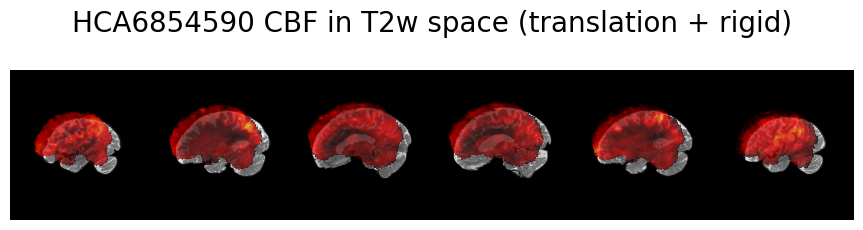

In [178]:
res = ants.apply_transforms(
    fixed=T2w_native_img,
    moving=cbf_native_img,
    transformlist=[asl_native_2_t2w_trans, asl_native_2_t2w_rigid],
    output=None,
    verbose=False,
    whichtoinvert=[False,False]
)
# ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
T2w_native_img.plot(overlay=res, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      title=f'{ID} CBF in T2w space (translation + rigid)')

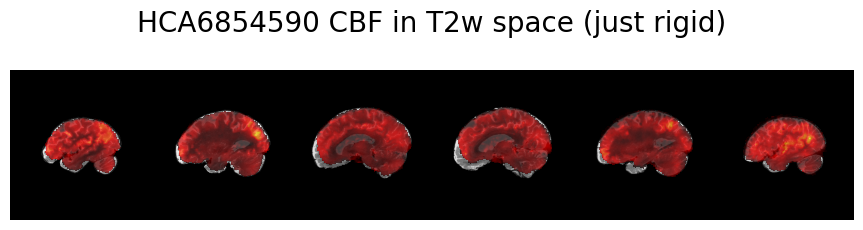

In [179]:
res = ants.apply_transforms(
    fixed=T2w_native_img,
    moving=cbf_native_img,
    transformlist=[asl_native_2_t2w_rigid],
    output=None,
    verbose=False,
    whichtoinvert=[False]
)
# ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
T2w_native_img.plot(overlay=res, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      title=f'{ID} CBF in T2w space (just rigid)')

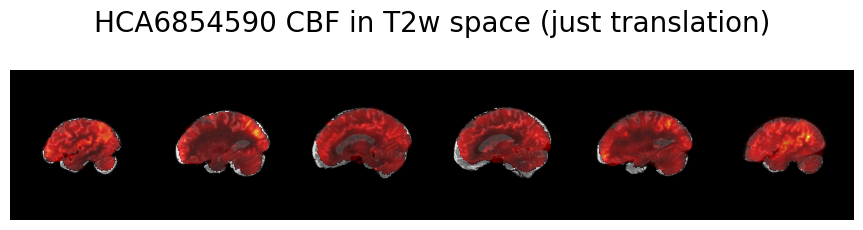

In [180]:
res = ants.apply_transforms(
    fixed=T2w_native_img,
    moving=cbf_native_img,
    transformlist=[asl_native_2_t2w_trans],
    output=None,
    verbose=False,
    whichtoinvert=[False]
)
# ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
T2w_native_img.plot(overlay=res, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      title=f'{ID} CBF in T2w space (just translation)')

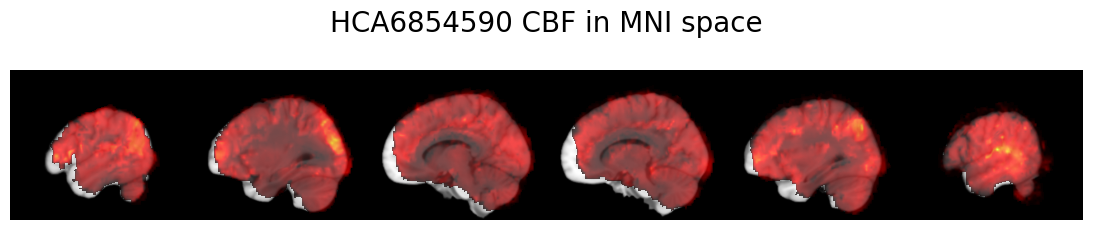

In [181]:
res = ants.apply_transforms(
    fixed=MNI_standard_img,
    moving=cbf_native_img,
    transformlist=[asl_native_2_t2w_rigid, t1w_to_t2w_aff, t1w_to_MNI_warp, t1w_to_MNI_aff],
    output=join(project_dir,f'{ID}_cbf_mni.nii.gz'),
    verbose=False,
    whichtoinvert=[ False, True, False, False]
)
ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
MNI_standard_img.plot(overlay=res, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      title=f'{ID} CBF in MNI space')

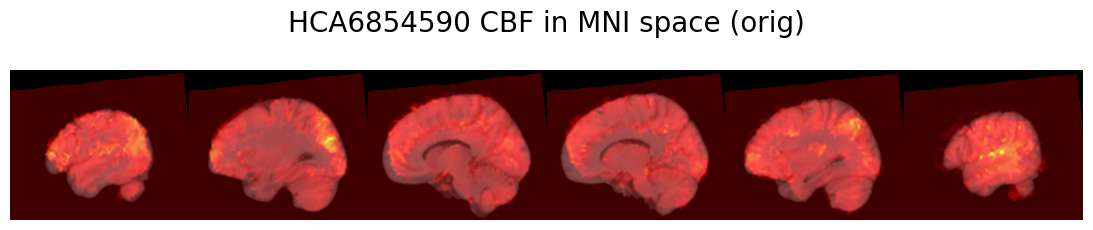

In [185]:
MNI_standard_img.plot(overlay=cbf_native_MNI_orig_img, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      title=f'{ID} CBF in MNI space (orig)')

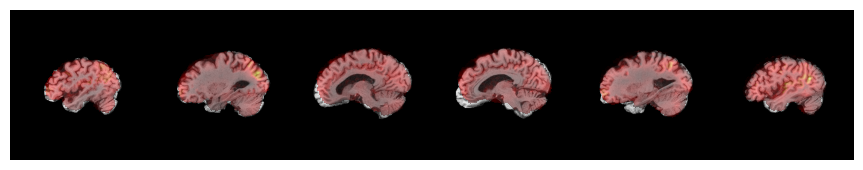

In [ ]:
res = ants.apply_transforms(
    fixed=T1w_native_img,
    moving=cbf_native_img,
    transformlist=[asl_native_2_t2w_rigid, t1w_to_t2w_aff],
    output=None,
    verbose=False,
    whichtoinvert=[False, False]
)
ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
T1w_native_img.plot(overlay=res, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.4,
                      nslices=6)
                      #title=f'{ID} CBF in T1w space')

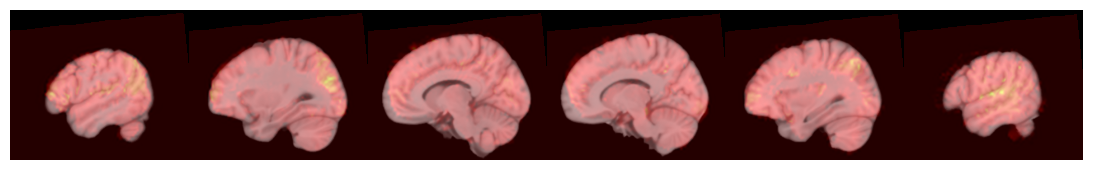

In [154]:
MNI_standard_img.plot(overlay=ants.image_read(join(project_dir,'HCA6854590_V1_MR_cbf_pve_use_May23_inMNI.nii')), 
                      overlay_cmap='hot', 
                      overlay_alpha=0.4,
                      nslices=6,
                      blend=False)

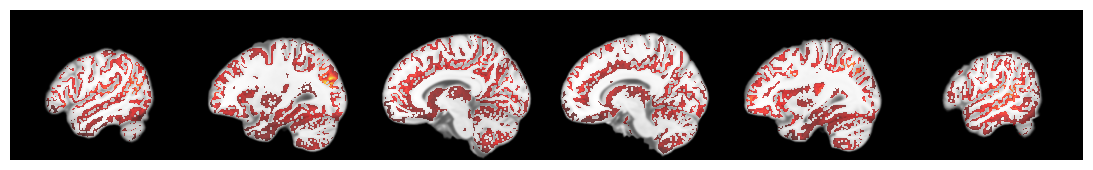

In [ ]:
MNI_standard_img.plot(overlay=ants.image_read(join(project_dir,'HCA6854590_V1_MR_cbf_pve_use_May23_inMNI_GM.nii.gz')), 
                      overlay_cmap='hot', 
                      overlay_alpha=0.7,
                      nslices=6,
                      blend=False)

# Look at how PVEs overlay w/ our original CBF native space

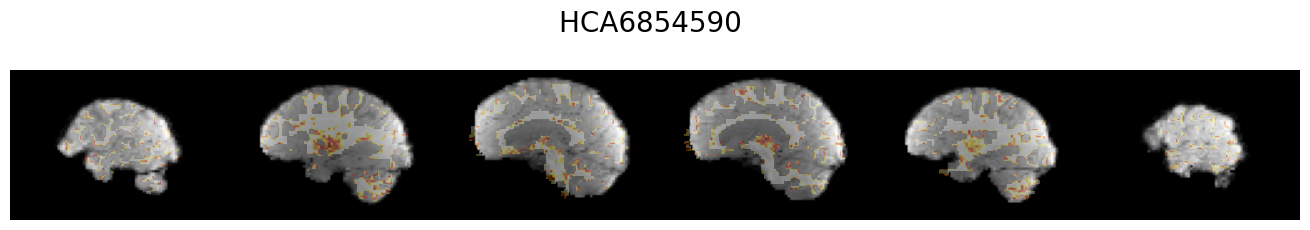

In [149]:
ID = 'HCA6854590'
project_dir = os.path.expanduser('~/Downloads/HCPA/')
root_dir = os.path.expanduser(f'~/Downloads/HCPA/{ID}_V1_MR/unprocessed/')
cbf_native = join(root_dir, f'mbPCASLhr/{ID}_V1_MR_cbf_pve_use_May23.nii')
meanASL_native = join(root_dir, f'mbPCASLhr/{ID}_V1_MR_mbPCASLhr_PA_bet_mean_ras.nii.gz')

pve_ASL = join(root_dir,f'T1w_MPR_vNav_4e_e1e2_mean/{ID}_V1_MR_T1w_MPR_vNav_4e_e1e2_mean_bet_pve_2_inASL.nii.gz')


MNI_standard_img = ants.image_read(MNI_standard)
cbf_native_img = ants.image_read(cbf_native)
pve_ASL_img = ants.image_read(pve_ASL)
meanASL_native_img = ants.image_read(meanASL_native)

ants.image_write(res, join(project_dir,f'{ID}_cbf_mni.nii.gz'))
meanASL_native_img.plot(overlay=pve_ASL_img, 
                      overlay_cmap='hot', 
                      overlay_alpha=0.3,
                      nslices=6,
                      title=f'{ID} ')